In [11]:
import numpy as np
import os
import yaml
import pickle
import csv
import matplotlib
import h5py
import json

import torch
from torch.utils.data import DataLoader
import numpy as np # 1.19.0
import matplotlib.ticker as ticker
import torchvision
from scipy import stats
import matplotlib.patches as mpatches
from functools import partial
import matplotlib.pyplot as plt
from chainconsumer import ChainConsumer
import scipy
from tqdm import tqdm_notebook as tqdm
from pesummary.gw.file.strain import StrainData
import bilby
import pandas as pd
from pprint import pprint

import dingo.gw.dataset.generate_dataset 
from dingo.gw.dataset import WaveformDataset
import dingo.gw.training.train_builders
from dingo.gw.ASD_dataset.noise_dataset import ASDDataset
from dingo.gw.waveform_generator import WaveformGenerator, sum_contributions_m
from dingo.gw.domains import build_domain, build_domain_from_model_metadata
import dingo.gw.inference
from dingo.gw.inference.data_preparation import data_to_domain, get_event_data_and_domain, parse_settings_for_raw_data, load_raw_data
from dingo.gw.gwutils import get_window_factor
from dingo.gw.transforms import *
from dingo.core.models import PosteriorModel
from dingo.gw.inference import injection
from dingo.gw.inference.gw_samplers import GWSamplerGNPE, GWSampler


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
charizard_hex = ('#cd5241', '#084152', '#eede7b', '#207394', '#eeb45a', '#e64110', '#ff524a', '#f6a410', '#08398b', '#626262', '#833118')
plt.rcParams['text.usetex'] = False
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['font.size'] = 15
plt.rcParams['xtick.major.size'] = 5.0
plt.rcParams['xtick.minor.size'] = 3.0
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=charizard_hex)

In [14]:
with open("/data/nihargupte/projects/dingo-devel/tutorials/06_tgr/train_dir_SEOBNRv4HM_PA_O3_1600_HLV/metadata.yaml", "r") as f:
    metadata = yaml.safe_load(f)

outdir = f"/data/nihargupte/projects/dingo-devel/tutorials/06_tgr/dumps/GW151012/is"
labels = metadata["train_settings"]["data"]["inference_parameters"].copy()
labels.append("weights")
with h5py.File(outdir + "/dingo_samples_weighted.hdf5", "r") as f:
    a = f["samples"].fields(labels)[:]
    arr = np.empty((a.shape[0], len(labels)))
    for i in range(a.shape[0]):
        arr[i, :] = list(a[i])
weighted_dingo_samples = pd.DataFrame(arr, columns=labels)
# Killing high weighted samples increases in the ESS and makes the fit better, but not really valid 
lower_threshold = 0 # 1e-3
upper_threshold = 1e2
inds = np.where(np.logical_and(weighted_dingo_samples["weights"] < upper_threshold, weighted_dingo_samples["weights"] > lower_threshold))[0]
ess = np.sum(weighted_dingo_samples["weights"].iloc[inds]) ** 2 / np.sum(weighted_dingo_samples["weights"].iloc[inds] ** 2)
print(ess, ess/weighted_dingo_samples["weights"].shape[0], weighted_dingo_samples["weights"].shape[0])
weighted_dingo_samples.columns

22262.975541540312 0.04607680415741076 483171


Index(['chirp_mass', 'mass_ratio', 'chi_1', 'chi_2', 'theta_jn', 'dec', 'ra',
       'geocent_time', 'luminosity_distance', 'psi', 'domega220', 'dtau220',
       'weights'],
      dtype='object')

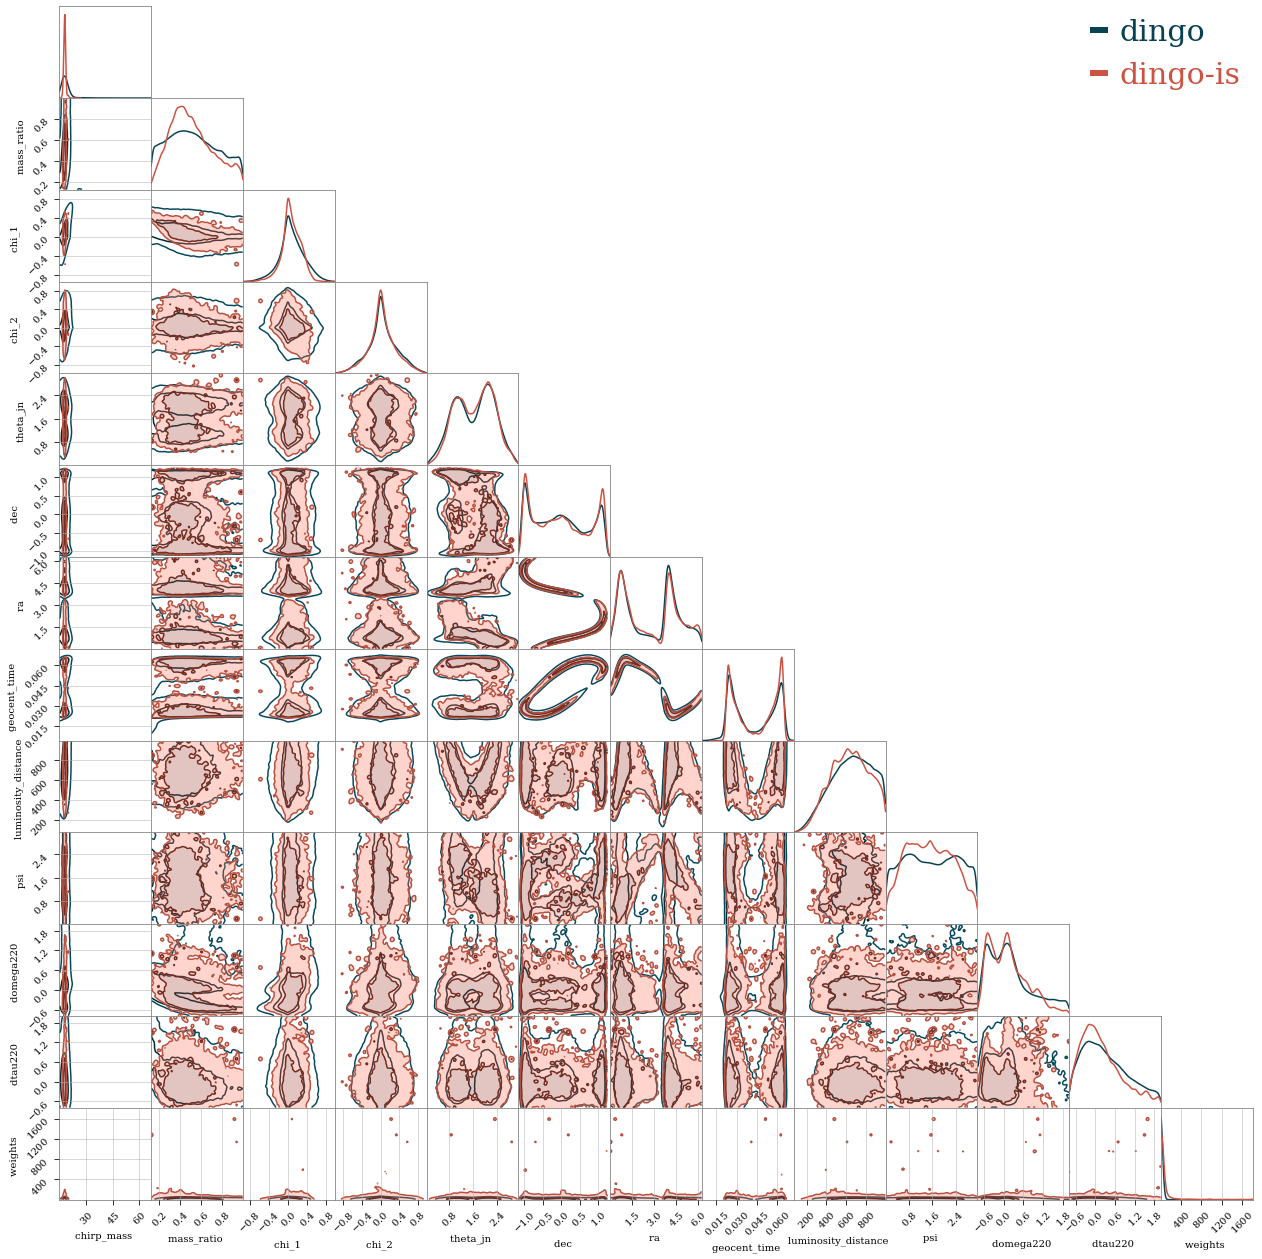

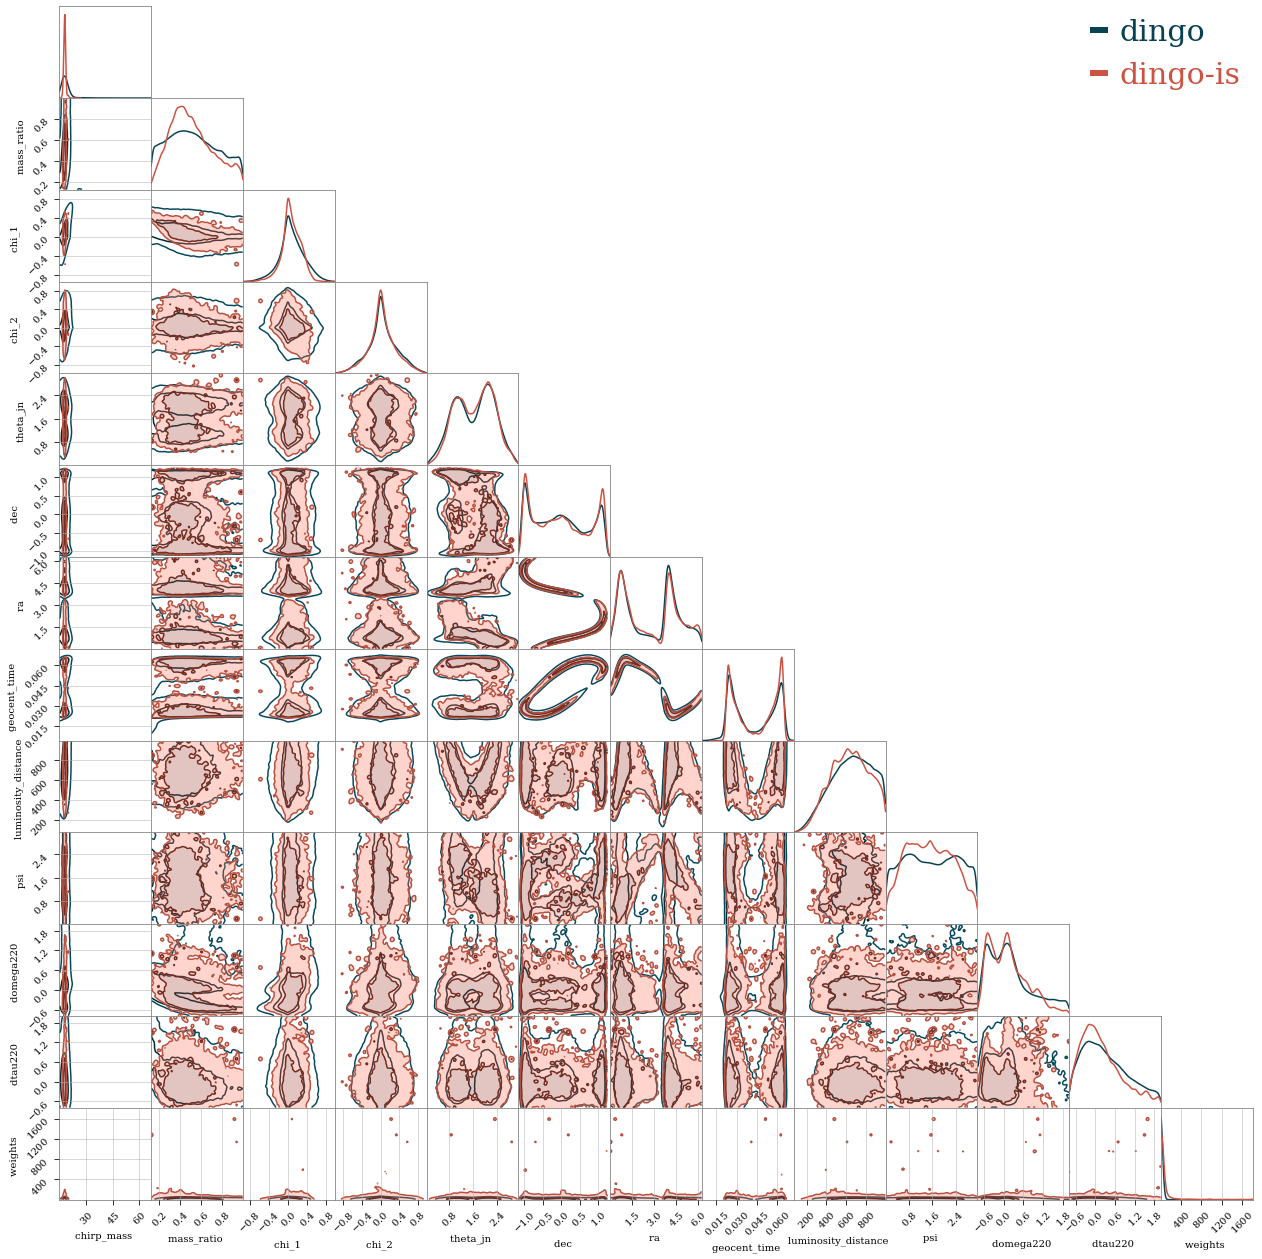

In [15]:
# First let's just plot weighted vs unweighted samples
N = 2
c = ChainConsumer()
c.add_chain(weighted_dingo_samples[labels], color=charizard_hex[1], name='dingo')
c.add_chain(weighted_dingo_samples[labels], color=charizard_hex[0], name='dingo-is', weights=weighted_dingo_samples["weights"])
c.configure(
    linestyles=["-"] * N,
    linewidths=[1.5] * N,
    sigmas=[np.sqrt(2) * scipy.special.erfinv(x) for x in [0.5, 0.9]],
    shade=[False] + [True] * (N - 1),
    shade_alpha=0.3,
    bar_shade=False,
    label_font_size=10,
    tick_font_size=10,
    usetex=False,
    legend_kwargs={"fontsize": 30},
    # kde=0.9
)
c.plotter.plot()

286.15324605413656 0.0011860930296494468 241257


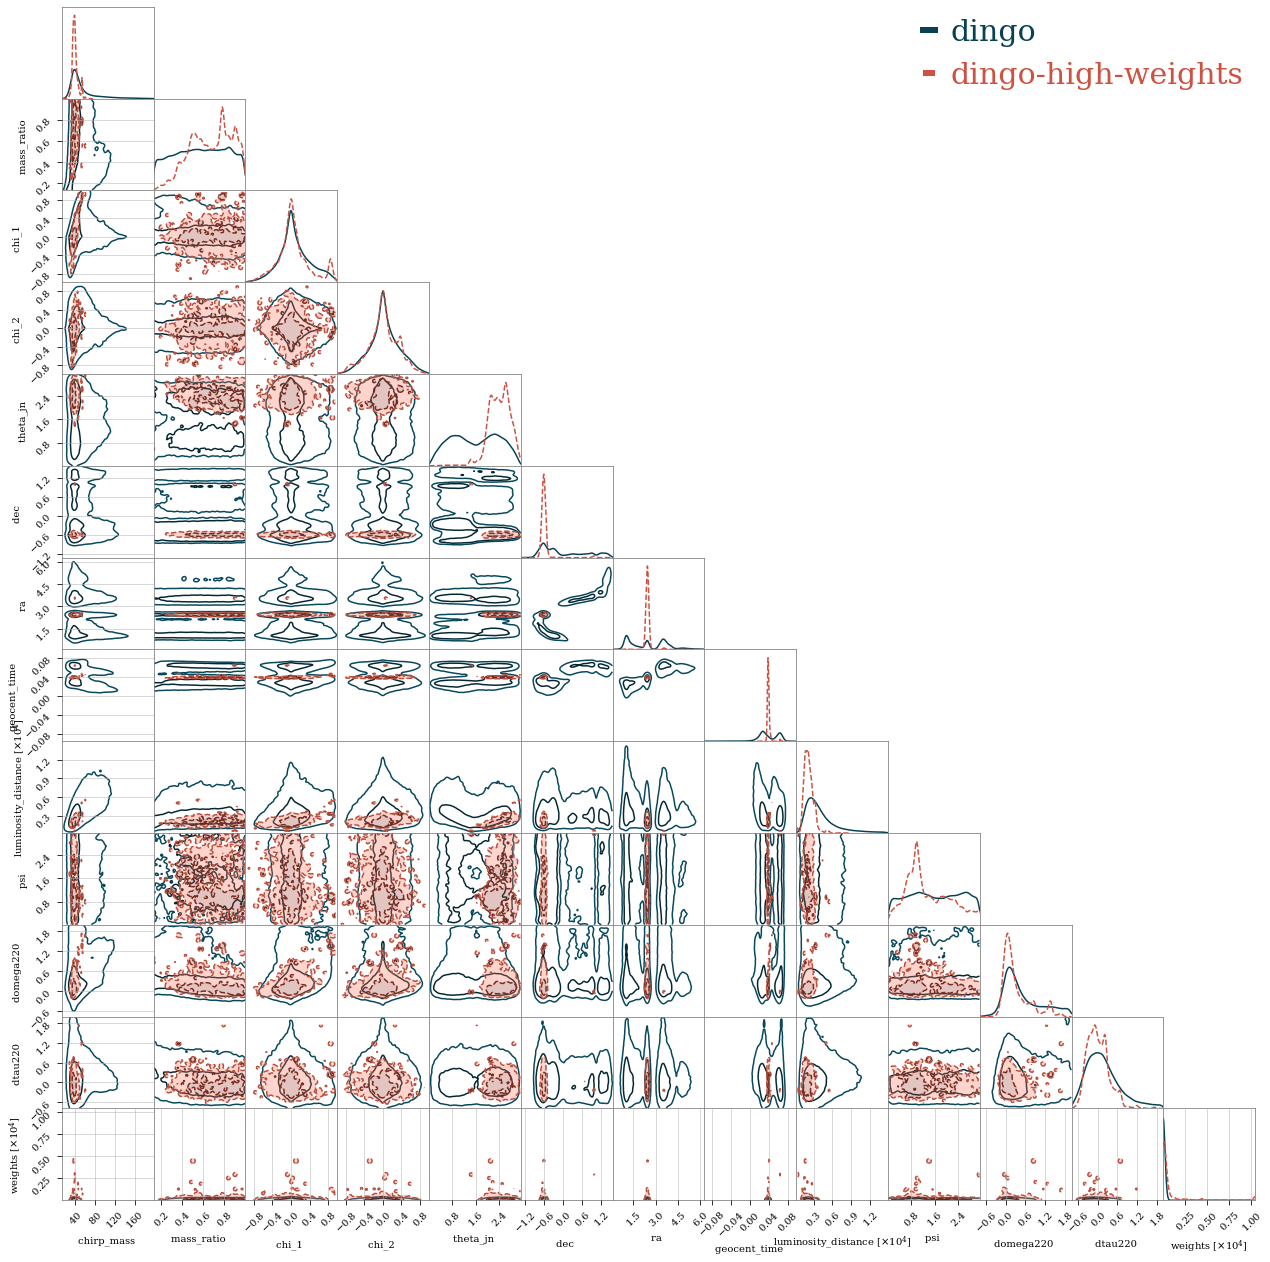

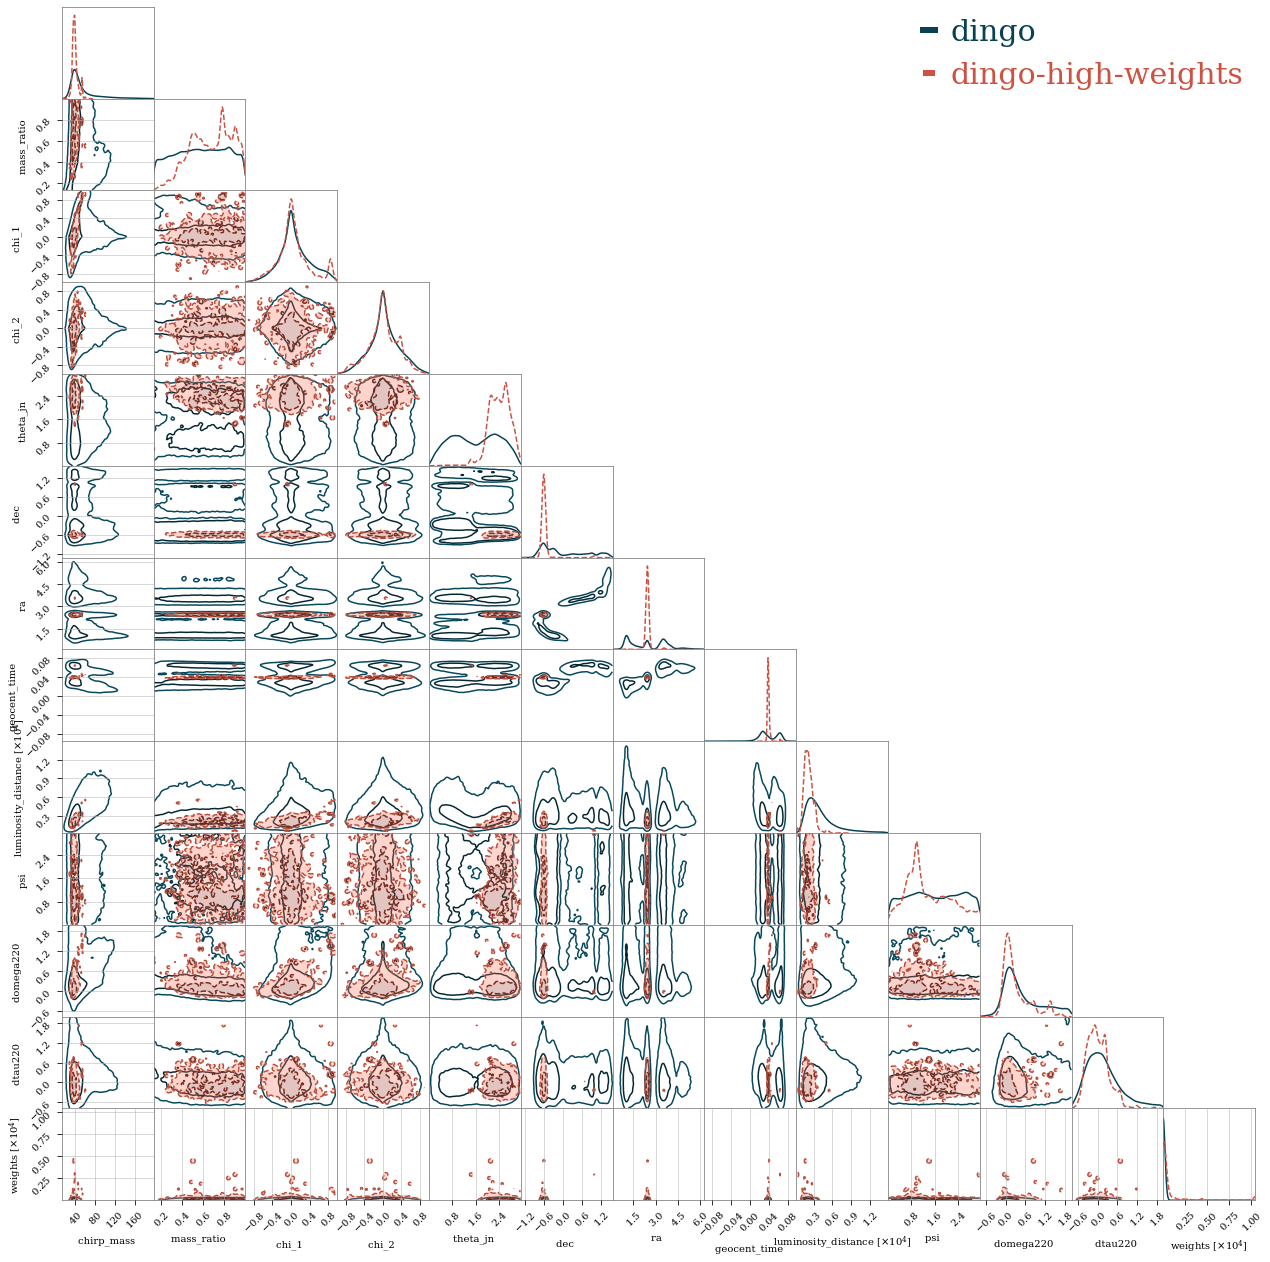

In [5]:
# Now let's plot only the high weight points
lower_threshold = 1
upper_threshold = 1e100
inds = np.where(np.logical_and(weighted_dingo_samples["weights"] < upper_threshold, weighted_dingo_samples["weights"] > lower_threshold))[0]
ess = np.sum(weighted_dingo_samples["weights"].iloc[inds]) ** 2 / np.sum(weighted_dingo_samples["weights"].iloc[inds] ** 2)
print(ess, ess/weighted_dingo_samples["weights"].shape[0], weighted_dingo_samples["weights"].shape[0])

N = 2
c = ChainConsumer()
c.add_chain(weighted_dingo_samples[labels], color=charizard_hex[1], name='dingo')
c.add_chain(weighted_dingo_samples[labels].iloc[inds], color=charizard_hex[0], name='dingo-high-weights', weights=weighted_dingo_samples["weights"].iloc[inds])
c.configure(
    linestyles=["-", "--"],
    linewidths=[1.5] * N,
    sigmas=[np.sqrt(2) * scipy.special.erfinv(x) for x in [0.5, 0.9]],
    shade=[False] + [True] * (N - 1),
    shade_alpha=0.3,
    bar_shade=False,
    label_font_size=10,
    tick_font_size=10,
    usetex=False,
    legend_kwargs={"fontsize": 30},
    # kde=0.9
)
c.plotter.plot()

184800
56457
[1.00000000e-20 1.73853888e-20]
[240831    264     79     36     17      7      7      1      2
      2      0      2      3      0      0      0      0      1
      0      1      0      0      0      0      1      0      0
      1      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      1      0      0
      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0
      1]


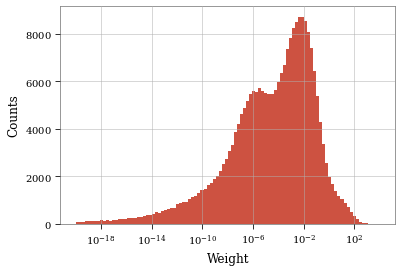

In [6]:
hist, bins = np.histogram(weighted_dingo_samples["weights"], bins=100)
a = weighted_dingo_samples["weights"].to_numpy()
a = a[np.nonzero(a)]
print(np.sum(weighted_dingo_samples["weights"] < 1e-2))
print(np.sum(weighted_dingo_samples["weights"] > 1e-2))
logbins = np.logspace(np.log10(bins[0] + 1e-20), np.log10(bins[-1]),len(bins))
print(logbins[0:2])
plt.xscale('log')
plt.xlabel("Weight")
plt.ylabel("Counts")
plt.hist(weighted_dingo_samples["weights"], bins=logbins)
print(hist)

/data/nihargupte/projects/dingo-devel/tgr_venv/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


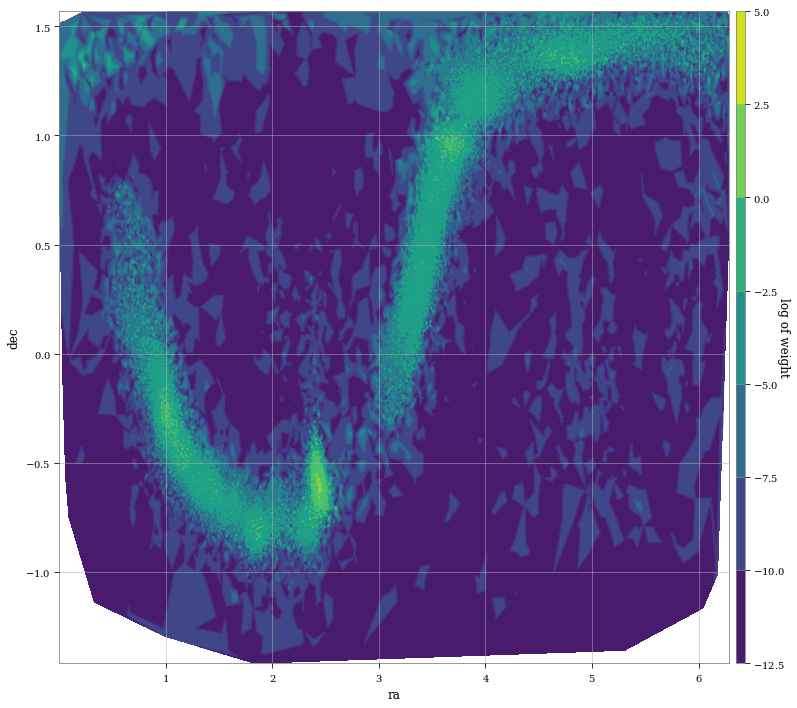

In [10]:
fig, ax = plt.subplots(1, figsize=(12, 12))
w = np.log10(weighted_dingo_samples["weights"])
mask = np.where(w > -12)[0]
ax.set_xlabel("ra")
ax.set_ylabel("dec")
trf = ax.tricontourf(weighted_dingo_samples["ra"].iloc[mask], weighted_dingo_samples["dec"].iloc[mask], w.iloc[mask])
cbar = ax.colorbar(trf)
cbar.set_label('log of weight', rotation=270)
trf = ax.tricontour(weighted_dingo_samples["ra"].iloc[mask], weighted_dingo_samples["dec"].iloc[mask], w.iloc[mask])
